# Gradient Estimation

In this notebook, we will consider the following simple **stochastic computation graph** as a running example:
![scg1](files/img/scg1.png)

$$
\begin{align}
\theta &\in [-\infty, +\infty] \\
x(\theta) &= \text{sigmoid}(\theta) = \frac{1}{1+e^{-\theta}} \\
y &\sim \mathcal{N}(\mu=x + 0.5, \sigma=0.1) \\
f(y) &= y(y - 2) \\
\end{align}
$$

This stochastic computation graph encodes the expected loss:
$$
\begin{equation}
\mathcal{L}(\theta) = \mathbb{E}_{y~\sim~p(\cdot~|~x(\theta))} [ f(y) ]
\end{equation}
$$

Our objective here is to compare the implementations of Gradient Estimation in **Numpy**, **TensorFlow with likelihood-ratio** and **TensorFlow with full Algorithmic-Differentiation** (AD).

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import utils

%matplotlib inline

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Hyper-parameters

In [2]:
learning_rate = 0.01
batch_size = 100000
epochs = 3000
theta_init = -1.0

# Gradient Estimation in Numpy

In [3]:
def forward(inputs, batch_size):
    theta = inputs
    x = 1 / (1 + np.exp(-theta))
    mu = x + 0.5
    sigma = 0.1
    y = np.random.normal(loc=mu, scale=sigma, size=(batch_size,))
    f = y * (y - 2)
    loss = np.mean(f)

    cache = {
        'x': x,
        'mu': mu,
        'sigma': sigma,
        'y': y,
        'f': f
    }

    return loss, cache

In [4]:
def backward(cache):
    f, y, mu, sigma, x = cache['f'], cache['y'], cache['mu'], cache['sigma'], cache['x']
    grad_log_mu = (y - mu) / np.square(sigma)
    grad_mu_x = 1.0
    grad_x_theta = x * (1 - x)
    grad_log_theta = grad_log_mu * grad_mu_x * grad_x_theta
    grad_loss_theta = np.mean(f * grad_log_theta)
    return grad_loss_theta

In [5]:
def SGD(learning_rate, theta_init, batch_size):
    theta = theta_init
    losses = []
    grads = []
    thetas = [theta_init]
    for step in range(epochs):
        loss, cache = forward(theta, batch_size)
        grad_loss_theta = backward(cache)
        theta = theta - learning_rate * grad_loss_theta
        losses.append(loss)
        grads.append(grad_loss_theta)
        thetas.append(theta)
    return losses, grads, thetas

In [6]:
losses, grads, thetas = SGD(learning_rate, theta_init, batch_size)

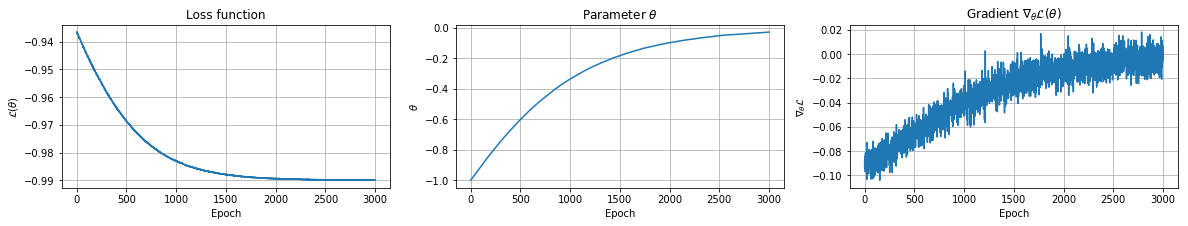

In [7]:
utils.plot_results(losses, thetas, grads)

# Gradient Estimation in TensorFlow (with likelihood ratio)

In [8]:
graph = tf.Graph()
with graph.as_default():

    # model
    theta = tf.Variable(initial_value=theta_init, dtype=tf.float32, name="theta")
    x = tf.sigmoid(theta, name="x")

    mu = tf.add(x, 0.5, name="mu")
    sigma = tf.constant(0.1, dtype=tf.float32, name="sigma")
    p_y = tf.distributions.Normal(loc=mu, scale=sigma, name='p_y')
    y = p_y.sample(sample_shape=(batch_size), name="y")

    f = tf.multiply(y, y-2, name="f")
    loss = tf.reduce_mean(f, name="loss")

    # gradient estimate
    log_prob = p_y.log_prob(y, name="log_prob")
    grad_log_theta, = tf.gradients(xs=theta, ys=(f * log_prob), stop_gradients=[y])
    grad_loss_theta = tf.divide(grad_log_theta, tf.cast(batch_size, tf.float32), name="grad_theta")

    # stochastic gradient descent
    new_theta = theta.assign(theta - learning_rate * grad_loss_theta)

In [9]:
with tf.Session(graph=graph) as sess:

    sess.run(tf.global_variables_initializer())
    
    losses = []
    grads = []
    thetas = [theta_init]

    for epoch in range(epochs):

        # evaluate graph
        loss_, grad_loss_theta_, theta_ = sess.run([loss, grad_loss_theta, theta])

        # optimize parameter
        sess.run(new_theta)
        
        # store results
        losses.append(loss_)
        grads.append(grad_loss_theta_)
        thetas.append(theta_)

        if epoch % 10 == 0:
            print('epoch = {:3d}, theta = {:6f}, loss = {:6f}, gradient = {:6f}\r'.format(epoch, theta_, loss_, grad_loss_theta_), end='')

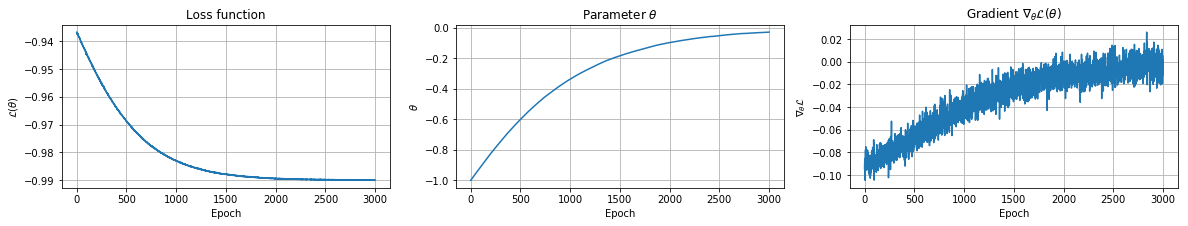

In [10]:
utils.plot_results(losses, thetas, grads)

# Gradient Estimation with TensorFlow (full AD)

In [11]:
graph = tf.Graph()
with graph.as_default():

    theta = tf.Variable(initial_value=-1.0, dtype=tf.float32, name="theta")
    x = tf.sigmoid(theta, name="x")

    mu = tf.add(x, 0.5, name="mu")
    sigma = tf.constant(0.1, name="sigma")
    y = tf.distributions.Normal(loc=mu, scale=sigma).sample(sample_shape=(batch_size), name="y")

    f = tf.multiply(y, y-2, name="f")
    loss = tf.reduce_mean(f, name="loss")

    # train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    grads_and_vars = optimizer.compute_gradients(loss)
    train_step = optimizer.apply_gradients(grads_and_vars, name='minimize')

In [12]:
with tf.Session(graph=graph) as sess:

    sess.run(tf.global_variables_initializer())

    losses = []
    grads = []
    thetas = [theta_init]

    for epoch in range(epochs):

        # evaluate graph
        theta_, loss_ = sess.run([theta, loss])
        thetas.append(theta_)
        losses.append(loss_)

        # optimize parameter
        grads_and_vars_ = sess.run(grads_and_vars)
        sess.run(train_step)
        
        # store results
        losses.append(loss_)
        grad_loss_theta_ = grads_and_vars_[0][0]
        grads.append(grad_loss_theta_)
        thetas.append(theta_)

        if epoch % 10 == 0:
            print('epoch = {:3d}, theta = {:6f}, loss = {:6f}, gradient = {:6f}\r'.format(epoch, theta_, loss_, grad_loss_theta_), end='')

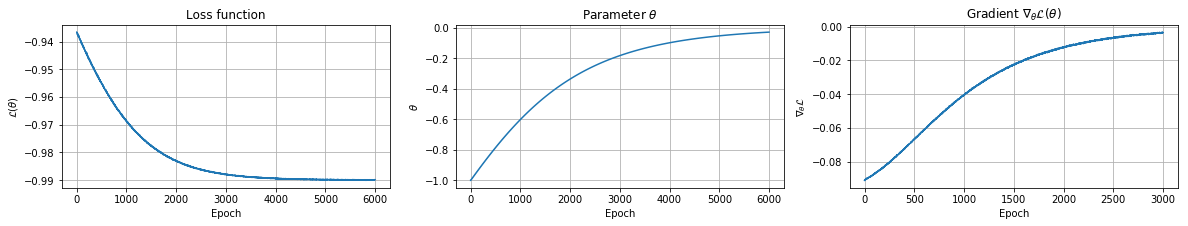

In [13]:
utils.plot_results(losses, thetas, grads)